# **PART 1 - Edge Detection and Hough Transform**

In [5]:
import cv2
import numpy as np
import os
import math
import matplotlib.pyplot as plt

# Function to calculate gradient magnitude
def sobel_edge_detection(image):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    # Calculating gradient magnitude
    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)

    # Normalizing the gradient magnitude
    gradient_magnitude = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    return gradient_magnitude

# Function to perform hough circle transform
def hough_circle_transform(image, min_radius, max_radius, threshold):
    # Getting the height and width of the image
    height, width = image.shape
    
    # Initializing an accumulator array with dimensions (height, width, max_radius - min_radius + 1)
    accumulator = np.zeros((height, width, max_radius - min_radius + 1))
    
    # Precomputing the cosine and sine values for each angle
    cos_theta = np.cos(np.radians(np.arange(0, 360)))
    sin_theta = np.sin(np.radians(np.arange(0, 360)))
    
    # Looping for each possible radius value
    for r in range(min_radius, max_radius + 1):
        # Looping for each possible angle value
        for theta in range(0, 360):
            # Calculating the possible center coordinates of the circle for each edge pixel
            a = np.around(np.nonzero(image)[0] - r * cos_theta[theta]).astype(int)
            b = np.around(np.nonzero(image)[1] - r * sin_theta[theta]).astype(int)
            # Checking if there is any center coordinates that are outside the image boundaries
            valid = np.where((a >= 0) & (a < height) & (b >= 0) & (b < width))
            # Incrementing the accumulator values at the valid center coordinates
            accumulator[a[valid], b[valid], r - min_radius] += 1
    
    # Initializing a list to store the detected circles
    circles = []
    
    # Looping for each pixel in the accumulator array
    for x in range(height):
        for y in range(width):
            for r in range(max_radius - min_radius + 1):
                if accumulator[x, y, r] >= threshold:
                    circles.append((x, y, r + min_radius))
    
    # Return the list of detected circles
    return circles

# Function to draw circles on the image
def draw_circles(image, circles):
    output_image = image.copy()

    for circle in circles:
        center = (circle[1], circle[0])
        radius = circle[2]
        cv2.circle(output_image,(center[0]*10,center[1]*10),radius*10, (255, 0, 0), 10)

    return output_image

# Function to apply non-maximum supression for finding one and true circle for each coin
def non_maximum_suppression(detected_circles, distance_threshold):
    # Sorting the circles by the accumulator value in descending order
    sorted_circles = sorted(detected_circles, key=lambda x: x[2], reverse=True)
    # Initializing a list to keep the circles 
    nms_circles = []

    # Looping for each circle and filtering them
    for circle in sorted_circles:
        x, y, radius = circle
        # Checking if the circle is far enough from other circles
        is_max = True
        for other_circle in nms_circles:
            other_x, other_y, other_radius, = other_circle
            distance = math.sqrt((x - other_x) ** 2 + (y - other_y) ** 2)
            if distance < distance_threshold * (radius + other_radius) / 2:
                is_max = False
                break
        if is_max:
            nms_circles.append(circle)

    return nms_circles

# Function to do all the process for images from reading to writing the output
def process_images(input_folder, output_folder, min_radius, max_radius):
    # Checking if the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Processing each image in the input folders (excluding Train folder which is removed later in assignment)
    for filename in os.listdir(input_folder):
        if input_folder != "Train":
            if filename.endswith(".jpg"):
                image_path = os.path.join(input_folder, filename)
                image = cv2.imread(image_path)

                # Resizing the images for getting an acceptable runtime, because they are too large
                org_resized = cv2.resize(image, (4000, int(image.shape[0] / image.shape[1] * 4000)))
                resized_image = cv2.resize(image, (int(org_resized.shape[1] / 10), int(org_resized.shape[0] / 10)))

                # Applying canny edge detection 
                image_gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
                image_blur = cv2.GaussianBlur(image_gray, (3, 3), 0)
                image_canny = cv2.Canny(image=image_blur, threshold1=20, threshold2=60)

                # Applying hough circle transform
                circles = hough_circle_transform(image_canny, min_radius, max_radius, 160)
                
                # Appying non maximum supression
                exact_circles = non_maximum_suppression(circles, 1)
                
                # Drawing circles on the output image
                output_image = draw_circles(org_resized, exact_circles)
                
                # Plotting the segmentation map
                fig, ax = plt.subplots(1,3,figsize=(18,6))
                ax[0].imshow(org_resized)
                ax[0].text(0.5, -0.05, 'Original image', ha='center', va='center', transform=ax[0].transAxes)
                ax[0].axis("off")

                ax[1].imshow(image_canny, cmap='gray')
                ax[1].text(0.5, -0.05, 'Edge detection', ha='center', va='center', transform=ax[1].transAxes)
                ax[1].axis("off")

                ax[2].imshow(output_image)
                ax[2].text(0.5, -0.05, 'Circle detection', ha='center', va='center', transform=ax[2].transAxes)
                ax[2].axis("off")
                plt.show()

                # Saving the result by writing the image
                output_path = os.path.join(output_folder, f"{filename.split('.')[0]}_hough.jpg")
                cv2.imwrite(output_path, output_image)


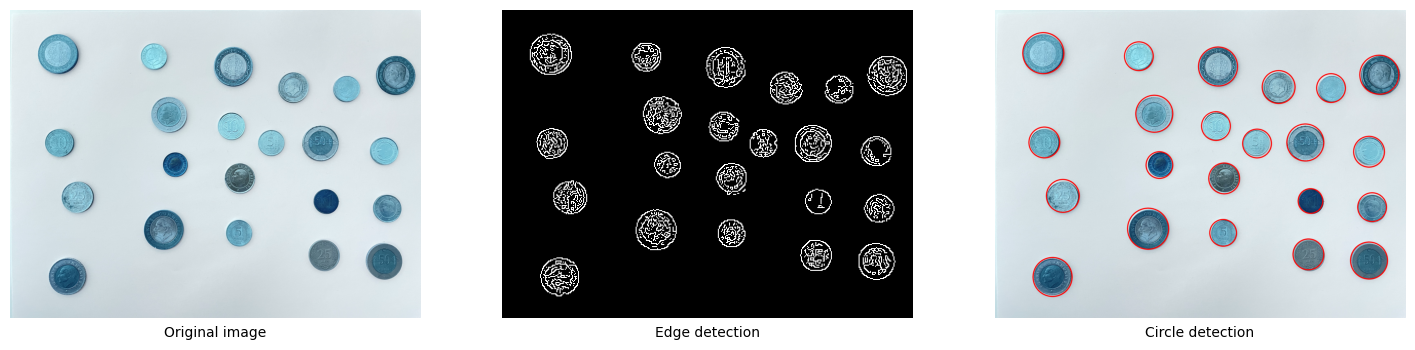

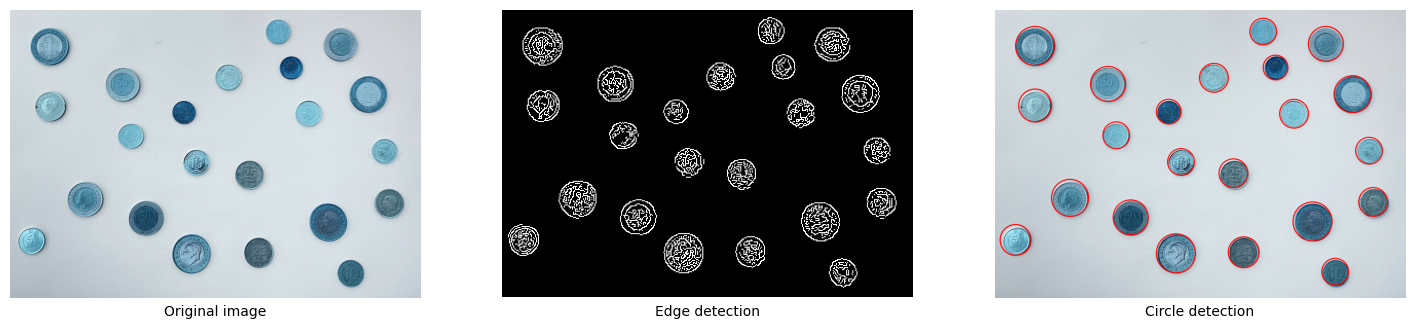

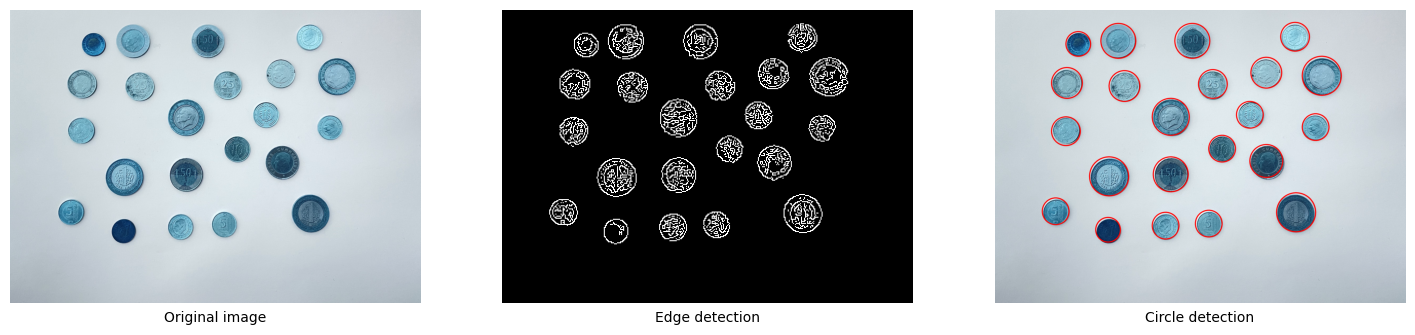

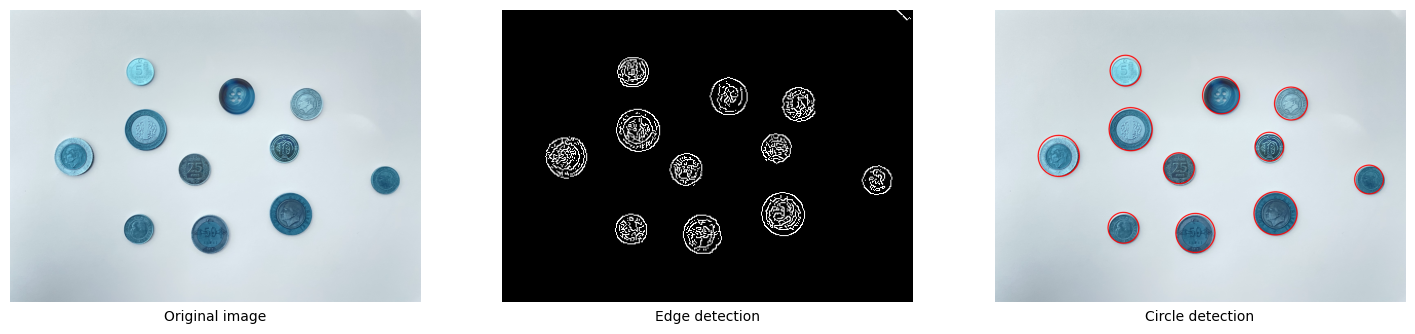

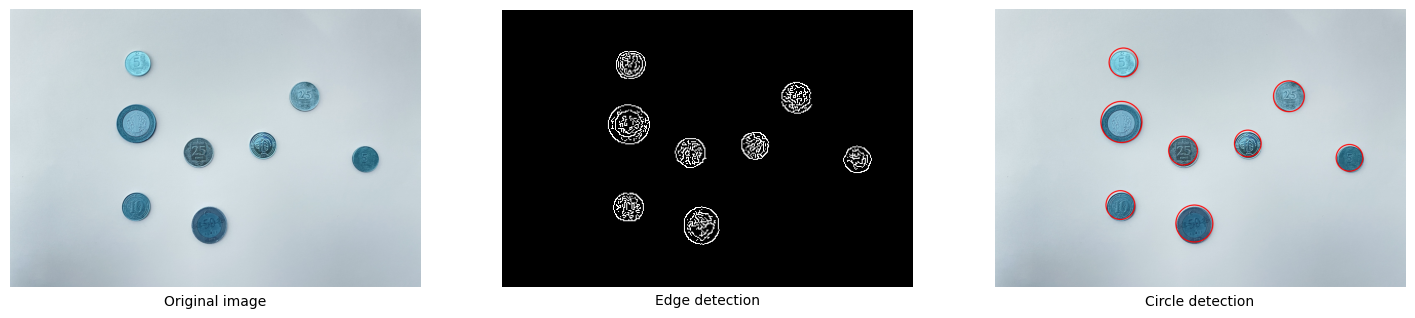

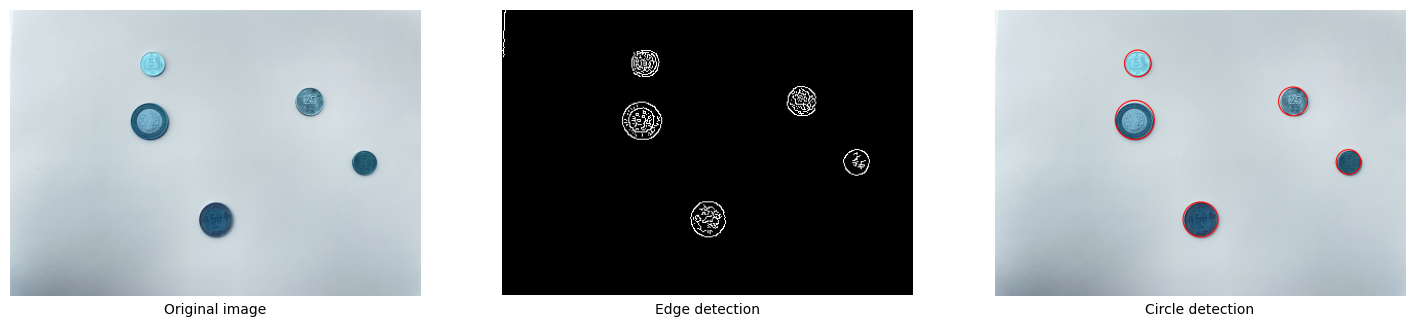

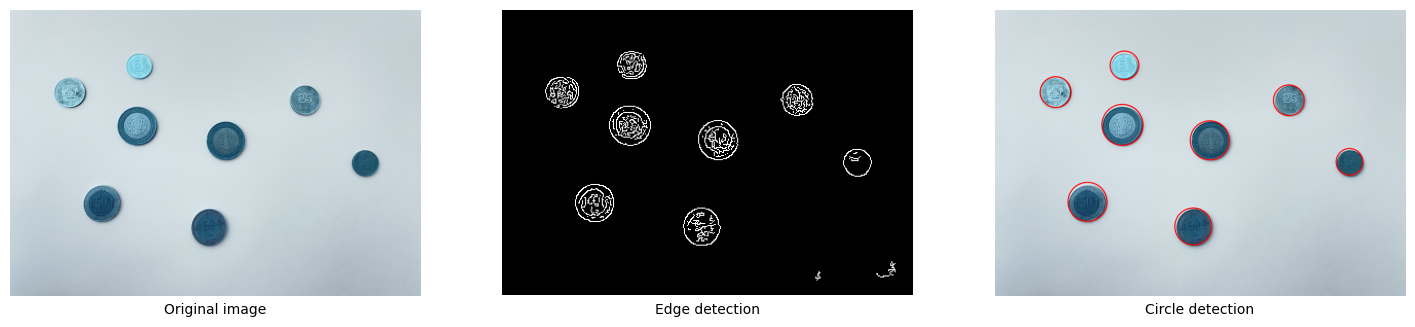

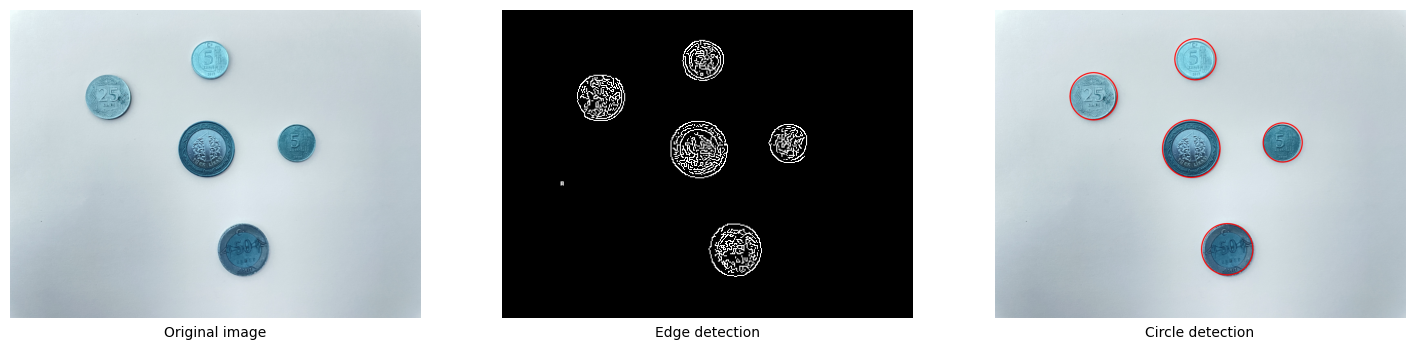

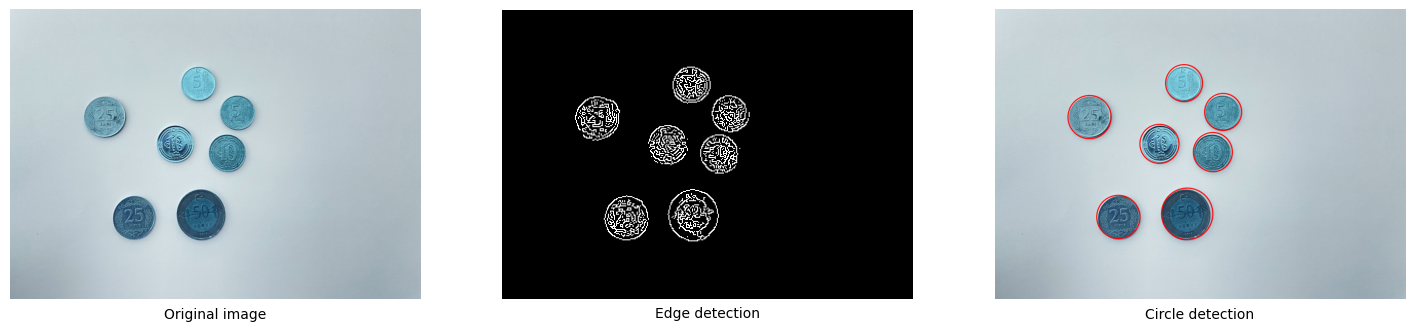

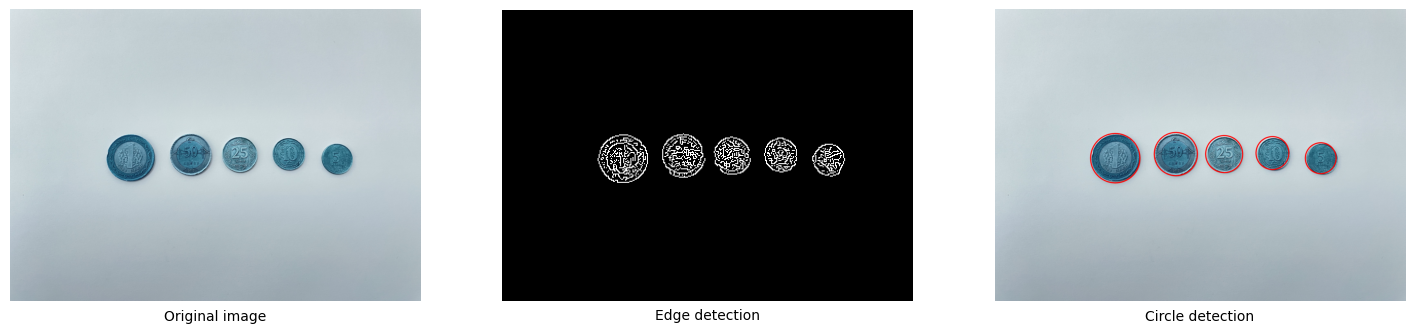

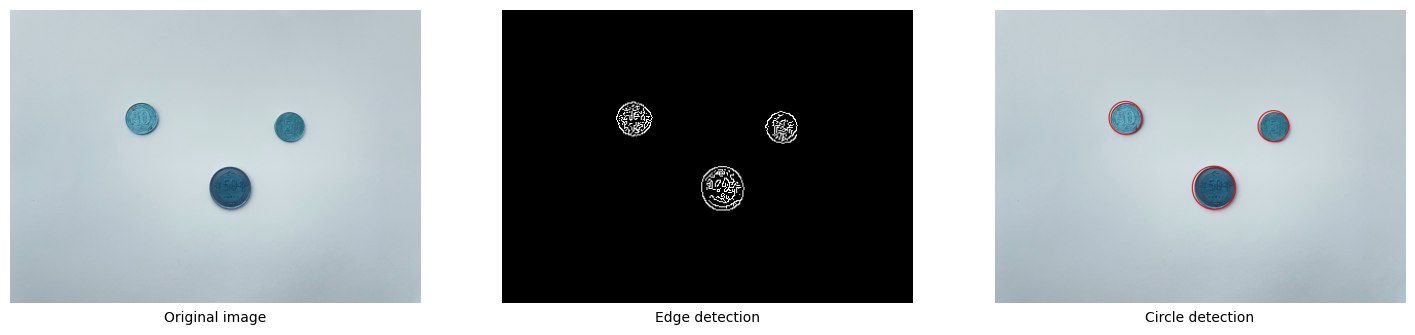

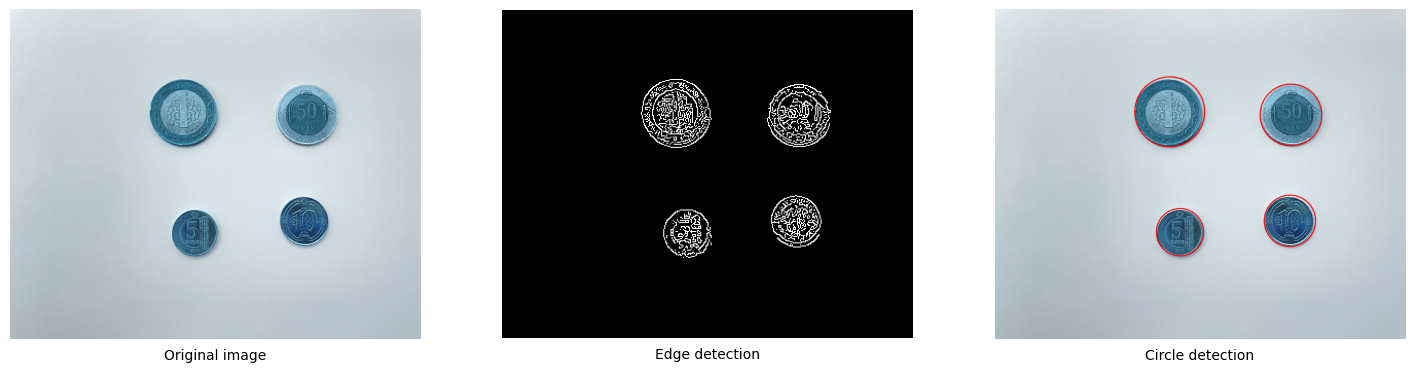

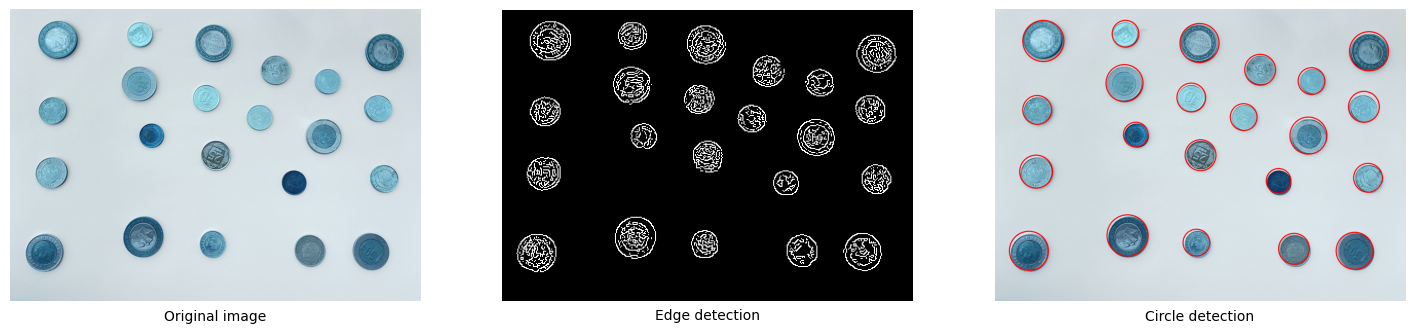

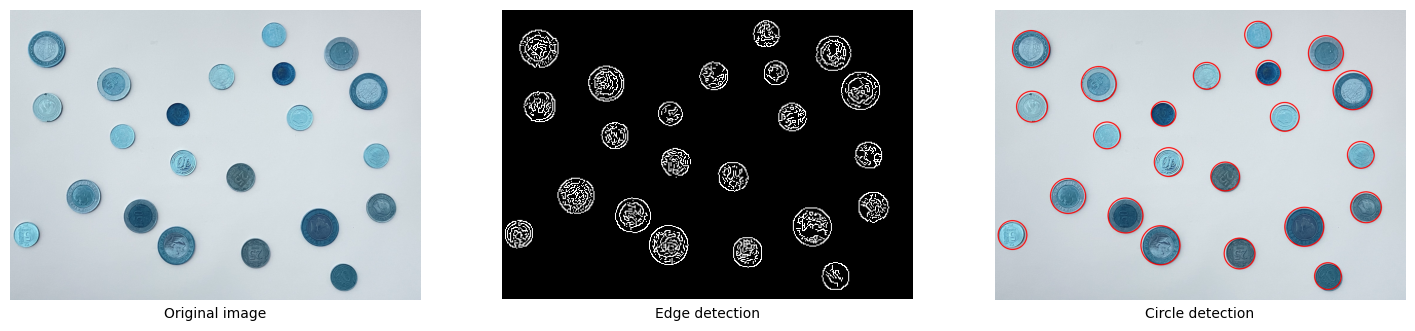

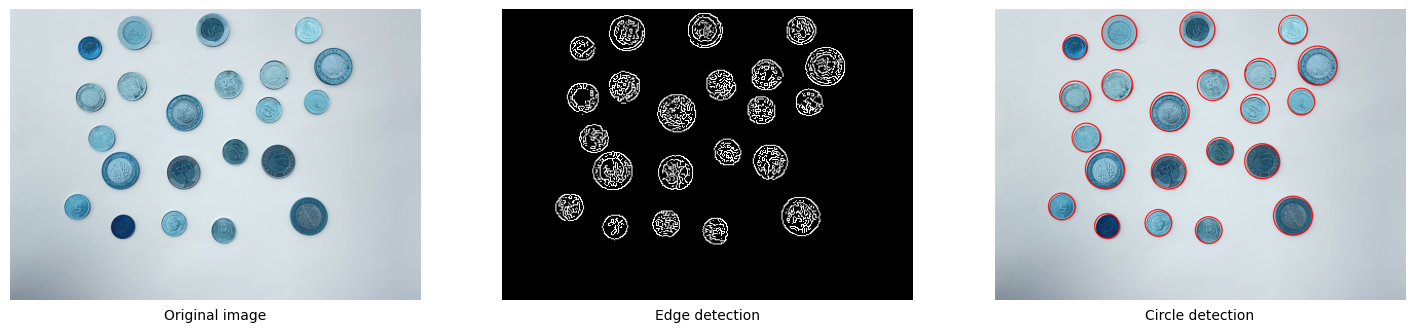

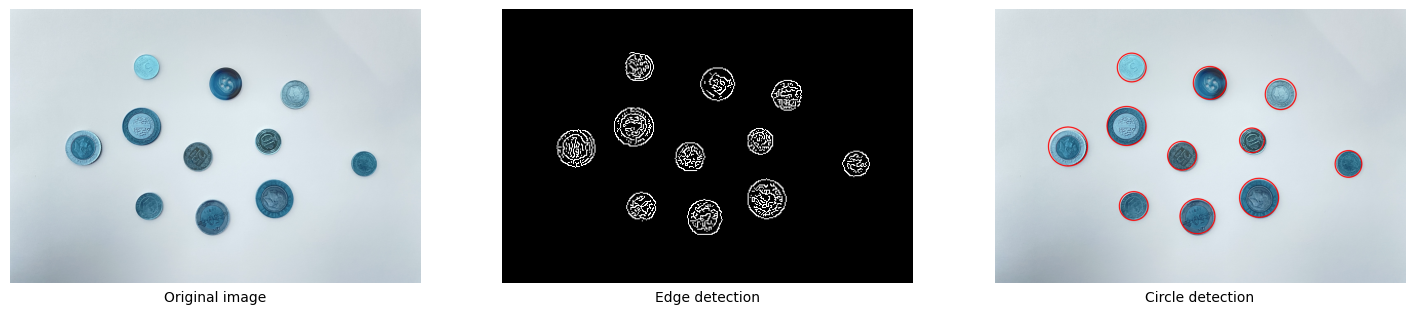

In [6]:
# Processing the "TestV" images
process_images("TestV", "TestV_Hough", min_radius=12, max_radius=36)

# Processing the "TestR" images
process_images("TestR", "TestR_Hough", min_radius=12, max_radius=36)


# **PART 2 - Histogram of Oriented Gradients** & Bonus

In [7]:
import numpy as np
import cv2
from sklearn import svm
import glob
import matplotlib.pyplot as plt
import os
from PIL import Image

# Function to calculate magnitude and direction of gradients by using sobel filter
def compute_gradients(image):
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    direction = np.arctan2(grad_y, grad_x) * (180 / np.pi) % 180
    
    return magnitude, direction

# Function to calculate histogram
def calculate_histogram(magnitude, direction, cell_size=(8, 8), bins=9):
    # Defining the number of cells per block
    cell_size_x, cell_size_y = cell_size
    
    # Calculating the number of cells in image
    num_cells_x = magnitude.shape[1] // cell_size_x
    num_cells_y = magnitude.shape[0] // cell_size_y
    
    # Initializing the histogram
    histogram = np.zeros((num_cells_y, num_cells_x, bins))
    
    # Looping for each cell in image
    for i in range(num_cells_y):
        for j in range(num_cells_x):
            # Extracting the cell region
            cell_magnitude = magnitude[i * cell_size_y:(i + 1) * cell_size_y,
                                       j * cell_size_x:(j + 1) * cell_size_x]
            cell_angle = direction[i * cell_size_y:(i + 1) * cell_size_y,
                               j * cell_size_x:(j + 1) * cell_size_x]
            
            # Calculating histogram for the cell
            hist, _ = np.histogram(cell_angle, bins=bins, range=(0, 180), weights=cell_magnitude)
            
            # Storing the histogram
            histogram[i, j, :] = hist
    
    return histogram

# Function to normalize histogram
def normalize_histogram(histogram, block_size=(2, 2)):
    # Defining the number of cells per block
    block_size_x, block_size_y = block_size
    
    # Calculating the number of blocks in image
    num_blocks_x = histogram.shape[1] - block_size_x + 1
    num_blocks_y = histogram.shape[0] - block_size_y + 1
    
    # Initializing the normalized histogram
    normalized_histogram = []
    
    # Looping for each block in image
    for i in range(num_blocks_y):
        for j in range(num_blocks_x):
            # Extracting the block region
            block = histogram[i:i + block_size_y, j:j + block_size_x].flatten()
            # Normalizing the block
            normalized_block = block / np.sqrt(np.sum(block**2) + 1e-5)
            # Storing the normalized block in the result array
            normalized_histogram.append(normalized_block)
    
    return np.concatenate(normalized_histogram)

# Function to extracting HoG features
def hog_features(image):
    magnitude, direction = compute_gradients(image)
    histogram = calculate_histogram(magnitude, direction)
    normalized_histogram_features = normalize_histogram(histogram)

    return normalized_histogram_features

# Function to detecting circles in image
def detect_circles(image, min_radius, max_radius):
    # Resizing the image
    org_resized = cv2.resize(image, (4000, int(image.shape[0] / image.shape[1] * 4000)))
    resized_image = cv2.resize(image, (int(org_resized.shape[1] / 10), int(org_resized.shape[0] / 10)))
    
    # Canny edge detection
    image_gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    image_blur = cv2.GaussianBlur(image_gray, (3, 3), 0)
    image_canny = cv2.Canny(image_blur, threshold1=30, threshold2=100)
    
    # Hough Circle Transform
    circles = hough_circle_transform(image_canny, min_radius, max_radius, 160)
    exact_circles = non_maximum_suppression(circles, 1)
    
    return exact_circles

# Function to calculate the padding values for making the image square
def calculate_padding(image, target_size):
    height, width = image.shape[:2] 
    dw = max(0, target_size - width)
    dh = max(0, target_size - height)
    up = dh // 2 
    down = dh - up
    left = dw // 2 
    right = dw - left 
    return up, down, left, right 

# Function to preprocess the training images
def train_images(image_path):
    image = cv2.imread(image_path)
    
    # Resizing the image
    if image.shape[1] > image.shape[0]:
        image = cv2.resize(image, (100, int(image.shape[0] / image.shape[1] * 100)))
    elif image.shape[0] > image.shape[1]:
        image = cv2.resize(image, (int(image.shape[1] / image.shape[0] * 100), 100))
    else:
        image = cv2.resize(image, (100,100))
    
    # Padding the image
    u,d,l,r = calculate_padding(image, 100)
    image_padded = cv2.copyMakeBorder(image,u,d,l,r,cv2.BORDER_CONSTANT, value=image[0,0].tolist())
    
    return image_padded

# Function to train SVM model
def train_svm(features, labels):
    clf = svm.SVC()
    clf.fit(features, labels)
    return clf

# Function that does all the process for an input folder in TestV and TestR
def detect_coins(folder, svm_model):
    # Checking if output folder exists
    os.makedirs(folder + "_HoG", exist_ok=True)
    
    # For loop for each image
    for filename in os.listdir(folder):
        if filename.endswith(".jpg"):
            image = cv2.imread(os.path.join(folder, filename))
            org_resized = cv2.resize(image, (4000, int(image.shape[0] / image.shape[1] * 4000)))
            output_image = org_resized.copy()
            
            # Detecting circles in the image
            circles = detect_circles(image, min_radius=12, max_radius=36)

            # Drawing the circles
            for (x,y,r) in circles:
                cv2.circle(output_image,(y*10,x*10),r*10, (255, 0, 0), 5)
            
            # Extracting HoG features for each detected circle
            for circle in circles:
                x, y, r = circle
                # Multiplying the coordinates by 10 because of i find the circles in the 1/10 resized image
                x, y, r = x*10, y*10, r*10

                # Finding ROI (region of interest) boundaries
                x1, y1 = max(x - r, 0), max(y - r, 0)
                x2, y2 = min(x + r, org_resized.shape[0]), min(y + r, org_resized.shape[1])
                roi = org_resized[x1:x2, y1:y2]

                # Resizing ROI
                if roi.shape[0] > roi.shape[1]:
                    roi = cv2.resize(roi, (100, int(roi.shape[0] / roi.shape[1] * 100)))
                elif roi.shape[1] > roi.shape[0]:
                    roi = cv2.resize(roi, (int(roi.shape[1] / roi.shape[0] * 100), 100))
                else:
                    roi = cv2.resize(roi, (100,100))
            
                # Padding ROI
                up, down, left, right = calculate_padding(roi, 100)
                roi_padded = cv2.copyMakeBorder(roi, up, down, left, right, cv2.BORDER_CONSTANT, value=roi[0,0].tolist())
            
                # Extracting HoG features for each ROI
                features = hog_features(roi_padded)
            
                # Predicting the coin class with SVM model
                pred_class = svm_model.predict(features.reshape(1,-1))[0]

                # Writing predicted labels on the image
                cv2.putText(output_image, pred_class, (y-r,x-r),cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,0), 3)

            plt.imshow(output_image)
            plt.axis("off")
            plt.show()

            # Saving the output image
            output_path = os.path.join(folder + "_HoG", filename)
            cv2.imwrite(output_path, output_image)
            

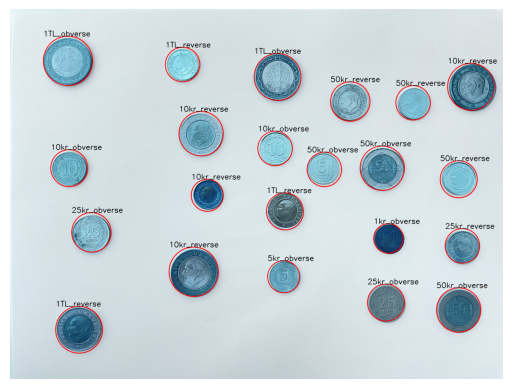

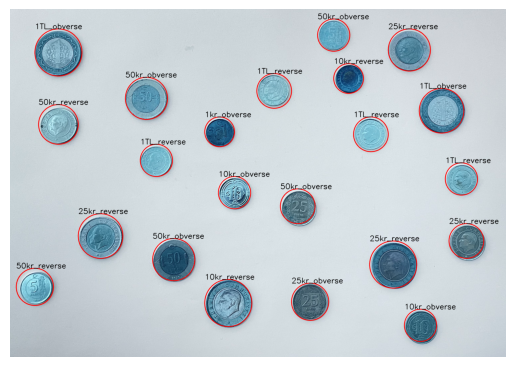

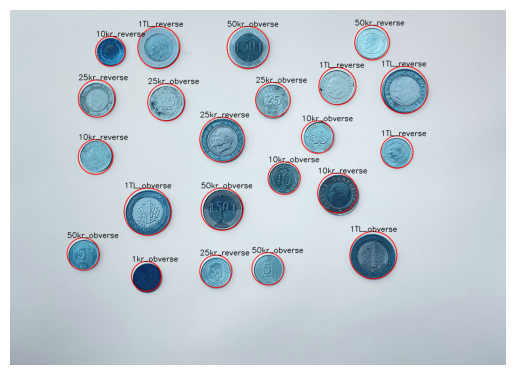

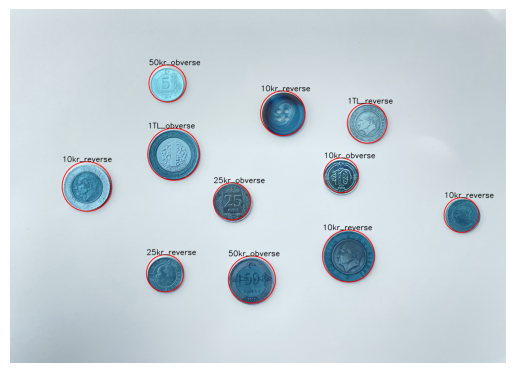

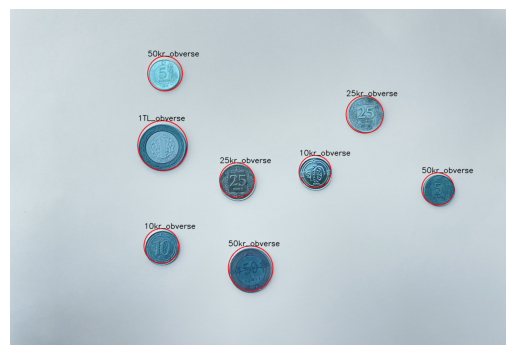

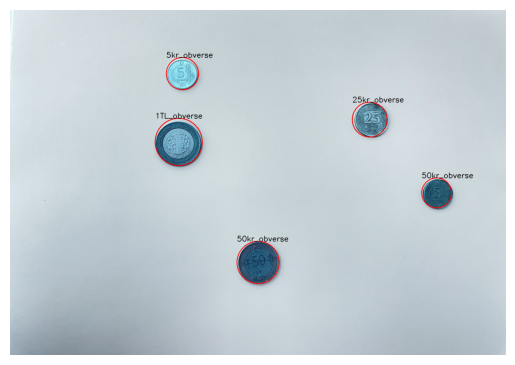

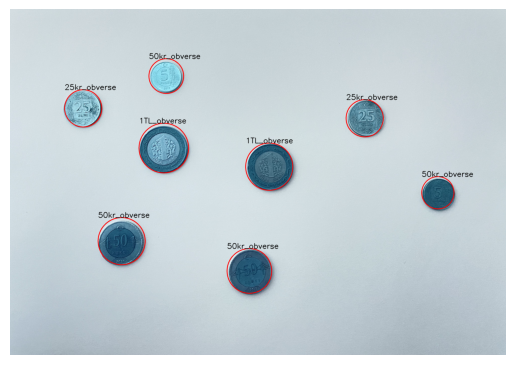

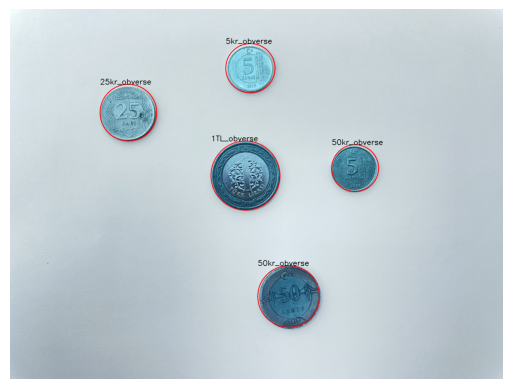

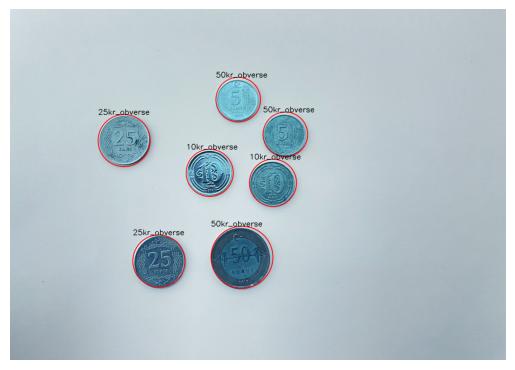

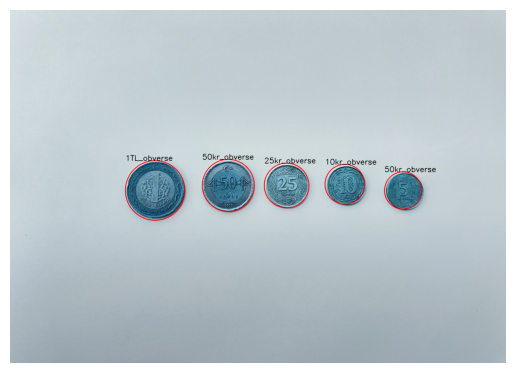

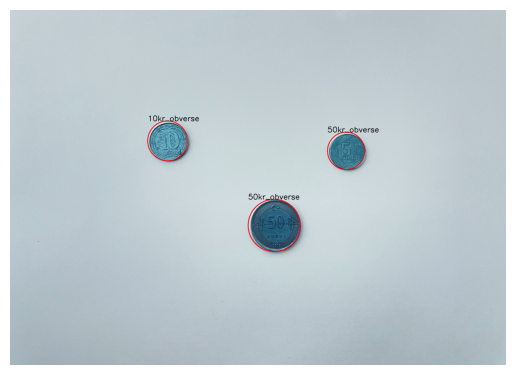

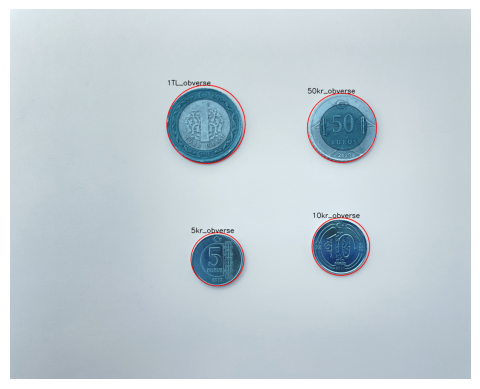

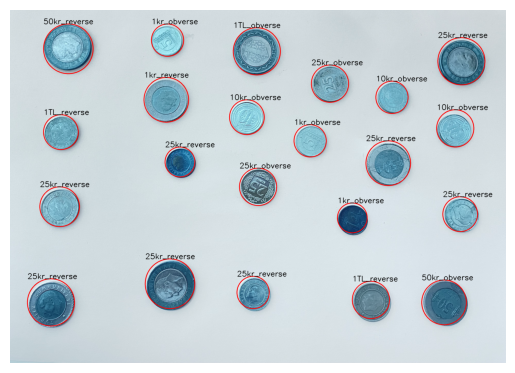

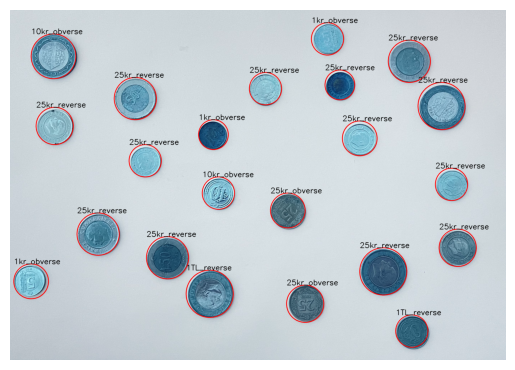

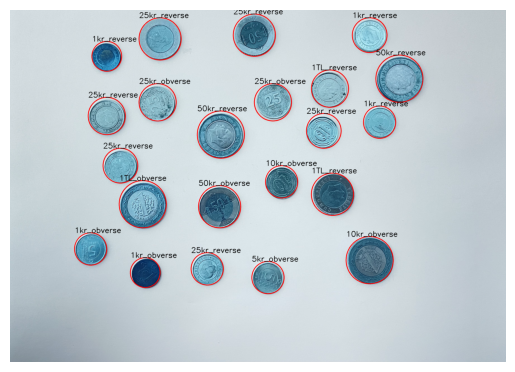

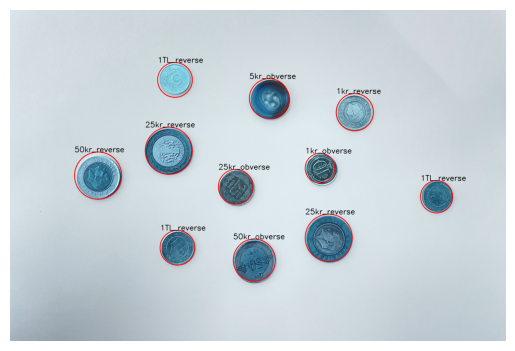

In [8]:
# Initializing arrays to store features and labels
featuresV = []
featuresR = []
labelsV = []
labelsR = []

train_image_paths = glob.glob(os.path.join('Train', '*jpg'))

# Looping the training images
for path in train_image_paths:
    image = train_images(path)

    # Extracting HoG features
    featureV = hog_features(image)
    
    # Getting labels
    filename = os.path.basename(path).split('_')
    label = filename[0] + "_" + filename[1]
    
    # Augmenting the training set for TestR where the coins can be rotated
    for angle in range(0, 360, 15):
        # Rotating the image repeatedly by 15 degrees
        rotated_image = np.array(Image.fromarray(image).rotate(angle))

        # Extracting HoG features
        featureR = hog_features(rotated_image)

        # Getting features and labels lists
        featuresR.append(featureR)
        labelsR.append(label)
    featuresV.append(featureV)
    labelsV.append(label)

# Converting them to a numpy array for to fit in model
X_v = np.array(featuresV)
y_v = np.array(labelsV)
X_r = np.array(featuresR)
y_r = np.array(labelsR)

# Training the models
svm_model_V = train_svm(X_v,y_v)
svm_model_R = train_svm(X_r,y_r)

# Process on test folders
detect_coins("TestV", svm_model_V)
detect_coins("TestR", svm_model_R)

